# Title of Your Group Project

This Python notebook serves as a template for your group project for the course "Modeling in Cognitive Science".

This is the practical part of the group project where you get to implement the computational modeling workflow. In this part, you are expected to:


*   Implement at least two computational models relevant for your hypothesis. *(3 points)*
*   Simulate behavior from the two models. *(3 points)*
*   Implement a procedure for fitting the models to data. *(4 points)*
*   Implement a procedure for parameter recovery. *(5 points)*
*   (Implement a procedure for model recovery.) *(optional; 2 bonus points)*
*   Implement a model comparison. *(5 points)*.

You can gain a total of 20 points for the practical part of the group project.

**Note:** *Some of the exercises below (e.g. Model Simulation) rely on code from previous exercises (e.g., Model Implementation). In such cases, you are encouraged to rely on functions implemented for previous exercises. That is, you don't have to produce redundant code.*



## Model Implementation *(3 points)*

For this exercise you should:

*   Implement and simulate data from two* models that are suitable to test your hypothesis. *(3 points)*

<font size=2>*You may implement more than two models if you wish. However, two models are sufficient for this group project.</font>

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [2]:
from simulate import simulate
from utils import save_simulated_data
# Run simulation and save to csv
agent_type = 'model_based'
# agent_type = 'model_free'
# agent_type = 'random'

task_df , agent= simulate(agent_type=agent_type)
# save_simulated_data(task_df, agent_type=agent_type)

q_table:
 [[0.5065751  0.57219379]
 [0.48769623 0.402949  ]
 [0.58582922 0.42568877]]
transition_matrix:
 [[0.         0.68686869 0.31313131]
 [0.         0.26732673 0.73267327]]
### model_based
common transitions percentage: 71.0 %
rewarded trails percentage: 53.0 %


,Rewarded,Common,Stay Probability,Condition
0,False,False,0.652,unrewarded_rare
1,False,True,0.700,unrewarded_common
2,True,False,0.676,rewarded_rare
3,True,True,0.597,rewarded_common


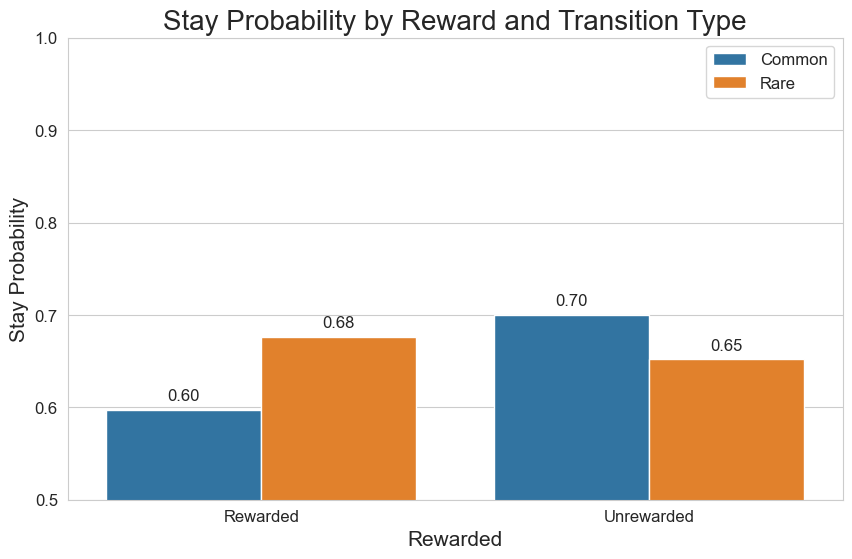

In [3]:
from utils import calculate_stay_probability, plot_stay_probability, plot_stay_probabilities, print_simple_statistics

# print q table and transition matrix
print("q_table:\n", agent.q_table)
if hasattr(agent, 'transition_model'):
    print("transition_matrix:\n", agent.transition_model[0])

# print some statistics 
print_simple_statistics(task_df, title=agent_type)

# calculate and plot stay probability
stay_probability_df, task_df_extended = calculate_stay_probability(task_df)
display(stay_probability_df)
plot_stay_probability(stay_probability_df)

# display(task_df_extended[['stepOneChoice', 'repeated_stepOneAction', 'repeated_stepOneAction_next','reward', 'common_transition']])


### experiment_data_andrei.csv
common transitions percentage: 71.5 %
rewarded trails percentage: 50.5 %


,Rewarded,Common,Stay Probability,Condition
0,False,False,0.406,unrewarded_rare
1,False,True,0.567,unrewarded_common
2,True,False,0.520,rewarded_rare
3,True,True,0.720,rewarded_common


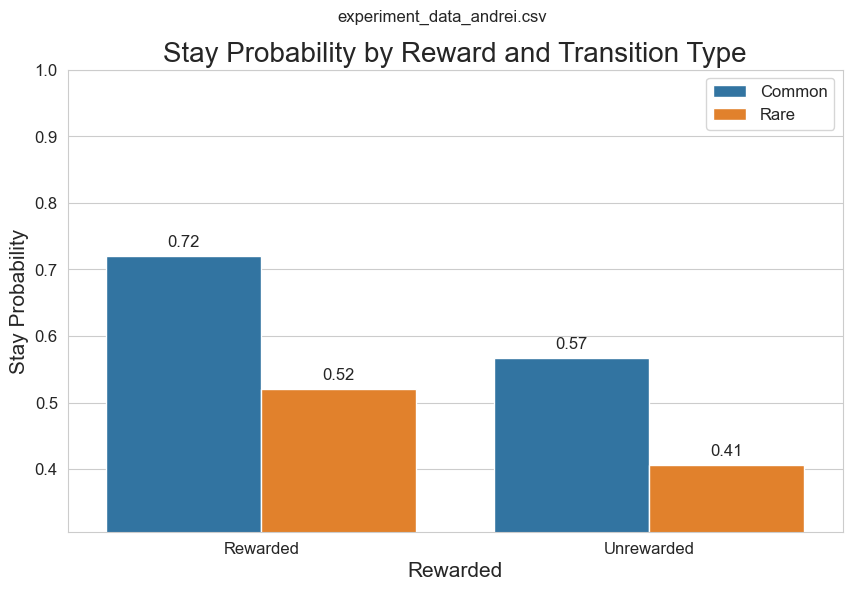

In [4]:
import pandas as pd
import os
from utils import preprocess_human_data, calculate_stay_probability, plot_stay_probability, print_simple_statistics

# load and inspect human data
particepant_data_file = "experiment_data_andrei.csv"
file_name = os.path.join("data", "participants", particepant_data_file)
human_data = pd.read_csv(file_name)

# preprocess human data
human_data = preprocess_human_data(human_data)

# print some statistics
print_simple_statistics(human_data, title=particepant_data_file)

# calculate and plot stay probability
stay_probability_df, human_data_extended = calculate_stay_probability(human_data)
display(stay_probability_df)
plot_stay_probability(stay_probability_df, title=particepant_data_file)

# display(human_data_extended[['stepOneChoice', 'repeated_stepOneAction', 'repeated_stepOneAction_next','reward', 'common_transition']])

## Model Simulation *(3 points)*

For this exercise you should:

*   Simulate data from both models for a single set of parameters. The simulation should mimic the experiment you are trying to model. *(2 points)*

*   Plot the simulated behavior of both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [5]:
from simulate import simulate
from utils import calculate_stay_probability, plot_stay_probability,\
                  plot_stay_probabilities, print_simple_statistics,\
                  save_simulated_data, preprocess_human_data
import os
import pandas as pd

# parameters



# Run simulation and save to csv

task_df_model_free, agent_model_free = simulate(agent_type='model_free')
task_df_model_based, agent_model_based = simulate(agent_type='model_based')
# task_df_random, agent_random = simulate(agent_type='random')
# save_simulated_data(task_df_model_based, agent_type='model_based')
# save_simulated_data(task_df_model_free, agent_type='model_free')
# load and inspect human data
particepant_data_file = "experiment_data_andrei.csv"
file_name = os.path.join("data", "participants", particepant_data_file)
human_data = pd.read_csv(file_name)
# preprocess human data
human_data = preprocess_human_data(human_data)

### Model Free
common transitions percentage: 73.0 %
rewarded trails percentage: 48.0 %
### Model Based
common transitions percentage: 71.5 %
rewarded trails percentage: 59.0 %
### Participant
common transitions percentage: 71.5 %
rewarded trails percentage: 50.5 %


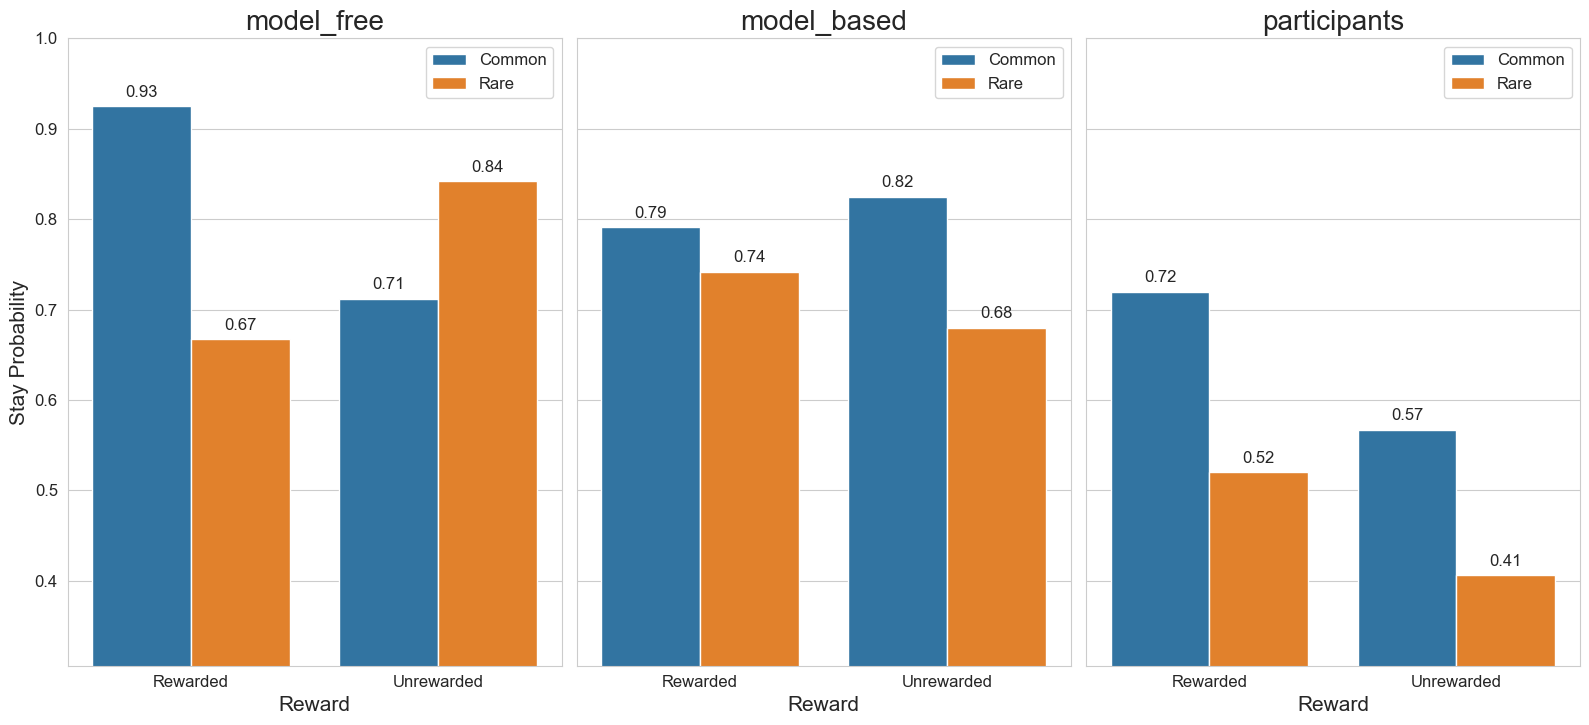

In [6]:
# print some statistics 
print_simple_statistics(task_df_model_free, title='Model Free')
print_simple_statistics(task_df_model_based, title='Model Based')
print_simple_statistics(human_data, title='Participant')

# calculate and plot stay probability
stay_probability_mf, _ = calculate_stay_probability(task_df_model_free)
stay_probability_mb, _ = calculate_stay_probability(task_df_model_based)
stay_probability_h, _ = calculate_stay_probability(human_data)

plot_stay_probabilities(dfs=[stay_probability_mf, stay_probability_mb, stay_probability_h],
                        labels=['model_free', 'model_based', 'participants'])

In [7]:
# plot progress across blocks
# stay probability across blocks
# reward across blocks
# best choice proportion across blocks


## Parameter Fitting *(4 points)*

For this exercise you should:

*   Set up a suitable parameter search space *(1 point)*

*   Implement a procedure to evaluate the fit of a model based on data *(2 points)*

*   Implement a procedure for searching the parameter space. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.



## Parameter Recovery *(5 points)*

For this exercise you should:

*   Set up a suitable space of parameters relevant for parameter recovery *(1 point)*

*   Use the functions above to generate behavior from a models, for a given set of (randomly sampled) parameters, and then fit the model to its generated data. Make sure to evaluate the parameter fit in a quantiative manner. *(3 points)*

*   Plot the parameter recovery results for both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [10]:
from utils import calculate_running_step_probabilities, plot_running_step_probabilities


# Generate behavior from the model
task_df = calculate_running_step_probabilities(task_df)
plot_running_step_probabilities(task_df, window_size=20)

# Generate behavior from the human data
human_data = calculate_running_step_probabilities(human_data)
plot_running_step_probabilities(human_data, window_size=20)

## *Optional*: Model Recovery *(2 bonus points)*

In this bonus exercise, you may examine model reovery. The bonus points count towards your total group project points. That is, you may accumlate up to 22 points in the practical part of the group project.

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [11]:
# YOUR MODEL RECOVERY CODE GOES HERE

## Model Comparison *(5 points)*

For this exercise you should:

*   Load and (potentially) preprocess the experimental data. (1 point)

*   Fit the two models to the data.  *(1 point)*

*   Evaluate which model performs better, taking into account fit and model complexity. *(2 points)*

*   Plot the behavior of the winning model against the data. *(1 point)**

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [12]:
# YOUR MODEL COMPARISON CODE GOES HERE